In [1]:
from pathlib import Path
from glob import glob

In [2]:
import numpy as np
import pandas as pd

import datasets

In [3]:
participants = [Path(file).name for file in glob('./data/ecg_preprocessed/*.csv')]

In [26]:
dataset = datasets.load_dataset(
    './data/ecg_preprocessed', 
    train_participants=participants[:1],
    trust_remote_code=True,
    num_proc=8
)['fit']

In [4]:
import matplotlib.pyplot as plt

In [5]:
plt.rcParams["figure.figsize"] = (30,10)

### T-Wave

In [6]:
df = pd.read_csv(f'./data/ecg_preprocessed/{participants[0]}')
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_5908\3499330255.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'./data/ecg_preprocessed/{participants[0]}')


,timestamp,signal,signal_normalised,subject_id,category,code,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,...,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,2017-12-15 10:16:06+00:00,-0.000073,0.493088,30100,NaN,NaN,-0.000073,-0.000095,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,2017-12-15 10:16:06.001000+00:00,-0.000083,0.492200,30100,NaN,NaN,-0.000083,-0.000097,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,2017-12-15 10:16:06.002000+00:00,-0.000095,0.491090,30100,NaN,NaN,-0.000095,-0.000100,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,2017-12-15 10:16:06.003000+00:00,-0.000103,0.490368,30100,NaN,NaN,-0.000103,-0.000102,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,2017-12-15 10:16:06.004000+00:00,-0.000110,0.489757,30100,NaN,NaN,-0.000110,-0.000105,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [7]:
import neurokit2 as nk

In [8]:
sampling_frequency = 1000
second = sampling_frequency
minute = 60 * second

In [14]:
def f_fr_n(freq, max_freq, l ):
    if freq < max_freq:
        return int(freq * l/max_freq)
    else:
        return l - 1

In [16]:
f_p_diff = np.diff(df[:minute][df[:minute]['ECG_R_Peaks'] == 1].index) * (1/1000)

T = minute * (1/1000)
k = np.arange(len(f_p_diff))
freqs = k/T
m = freqs.max()/2
l = int(len(freqs)/2)

ffts = abs(np.fft.fft(f_p_diff)*np.hamming(len(k)))**2
ULF = sum( ffts[ f_fr_n(0,m,l):f_fr_n(0.0033,m,l) ] )
VLF = sum( ffts[ f_fr_n(0.0033,m,l):f_fr_n(0.04,m,l) ] )
LF = sum( ffts[ f_fr_n(0.04,m,l):f_fr_n(0.15,m,l) ] )
HF = sum( ffts[ f_fr_n(0.15,m,l):f_fr_n(0.4,m,l) ] )
VHF = sum( ffts[ f_fr_n(0.4,m,l):f_fr_n(0.5,m,l) ] )
UHF = sum( ffts[ f_fr_n(0.5,m,l):f_fr_n(1,m,l) ] )

pd.DataFrame({ 'ULF': ULF, 'VLF': VLF, 'LF': LF, 'HF': HF, 'VHF': VHF, 'UHF': UHF }, index=[0])

,ULF,VLF,LF,HF,VHF,UHF
0,0,22.079151,0.050279,0.674407,0.055864,0


,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_UHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF
0,NaN,NaN,0.001592,0.001918,0.000114,0.000026,0.003651,0.829565,0.435953,0.52552,-6.256214


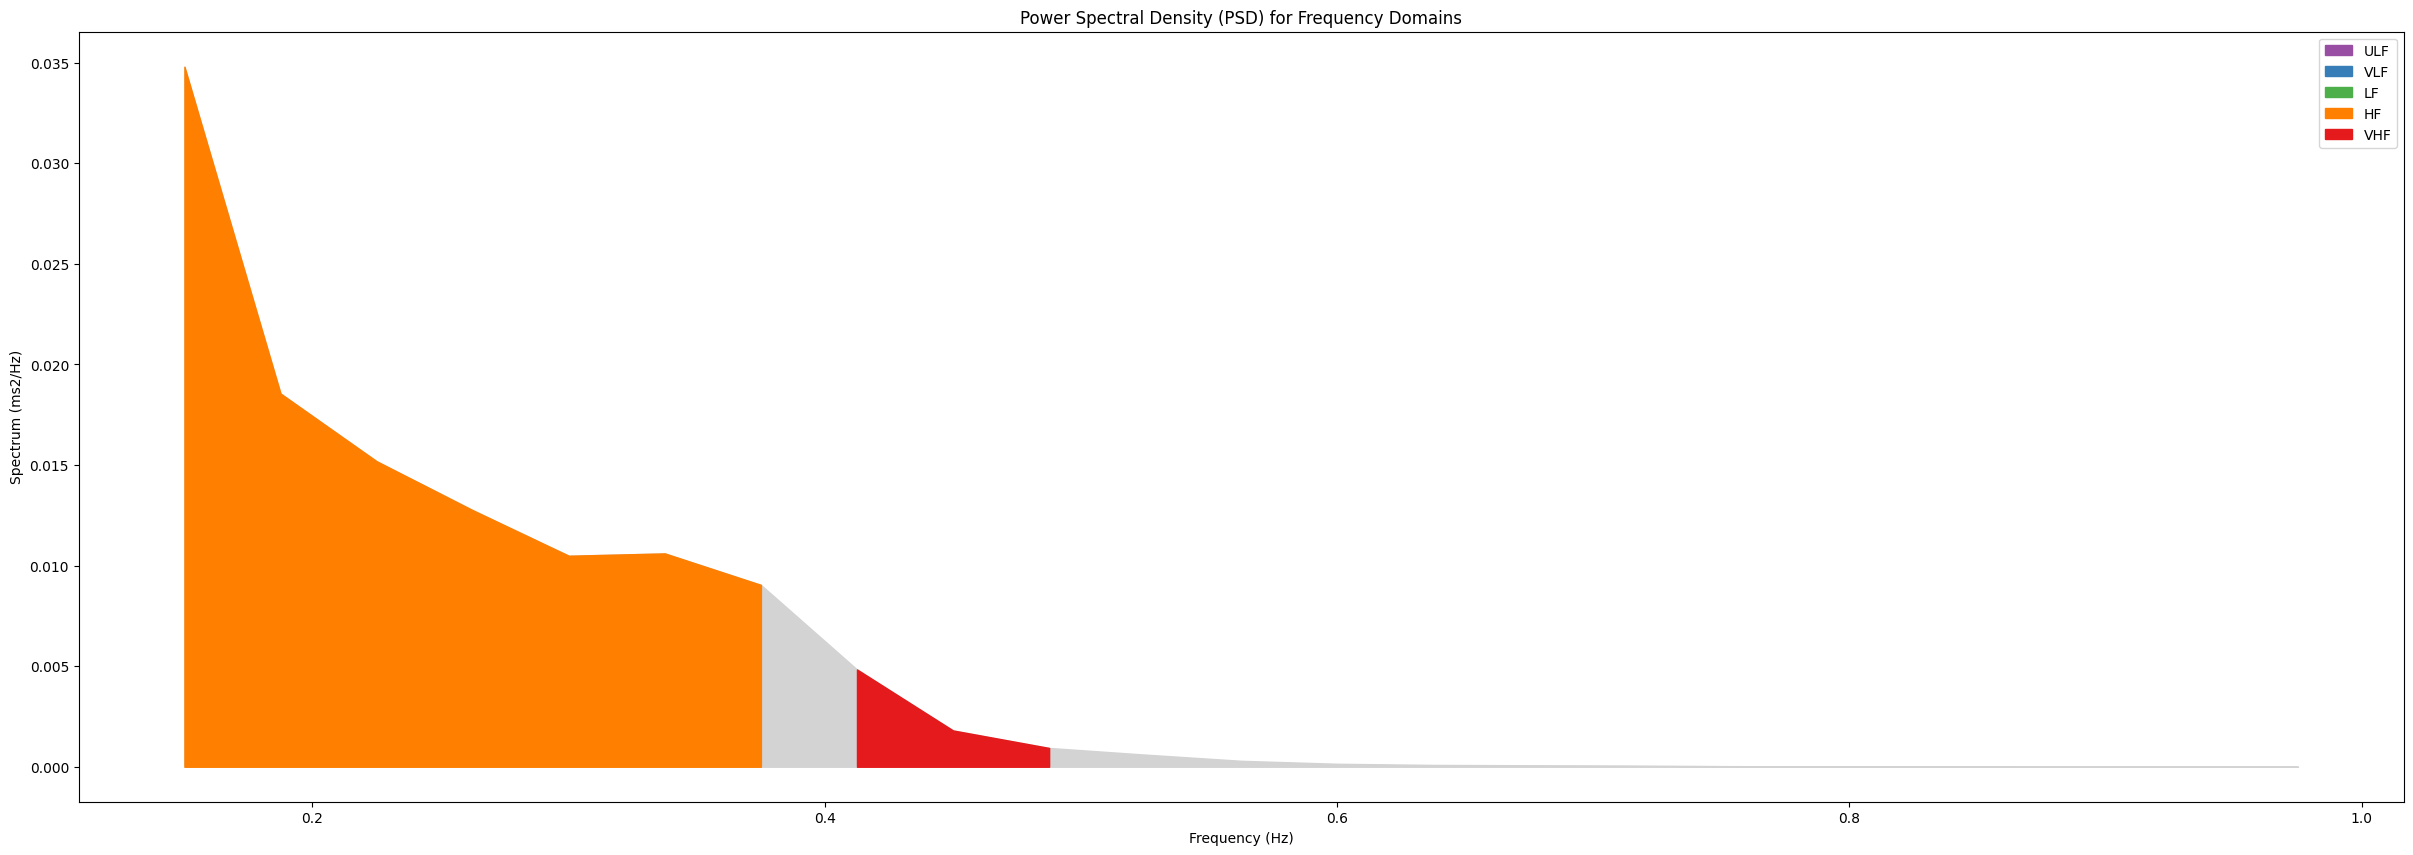

In [13]:
nk.hrv_frequency(df[:minute][df[:minute]['ECG_R_Peaks'] == 1].index, sampling_rate=1000, show=True)

,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_UHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF
0,NaN,NaN,0.001032,0.000555,0.000016,0.000013,0.001615,1.860731,0.638815,0.343314,-7.497424


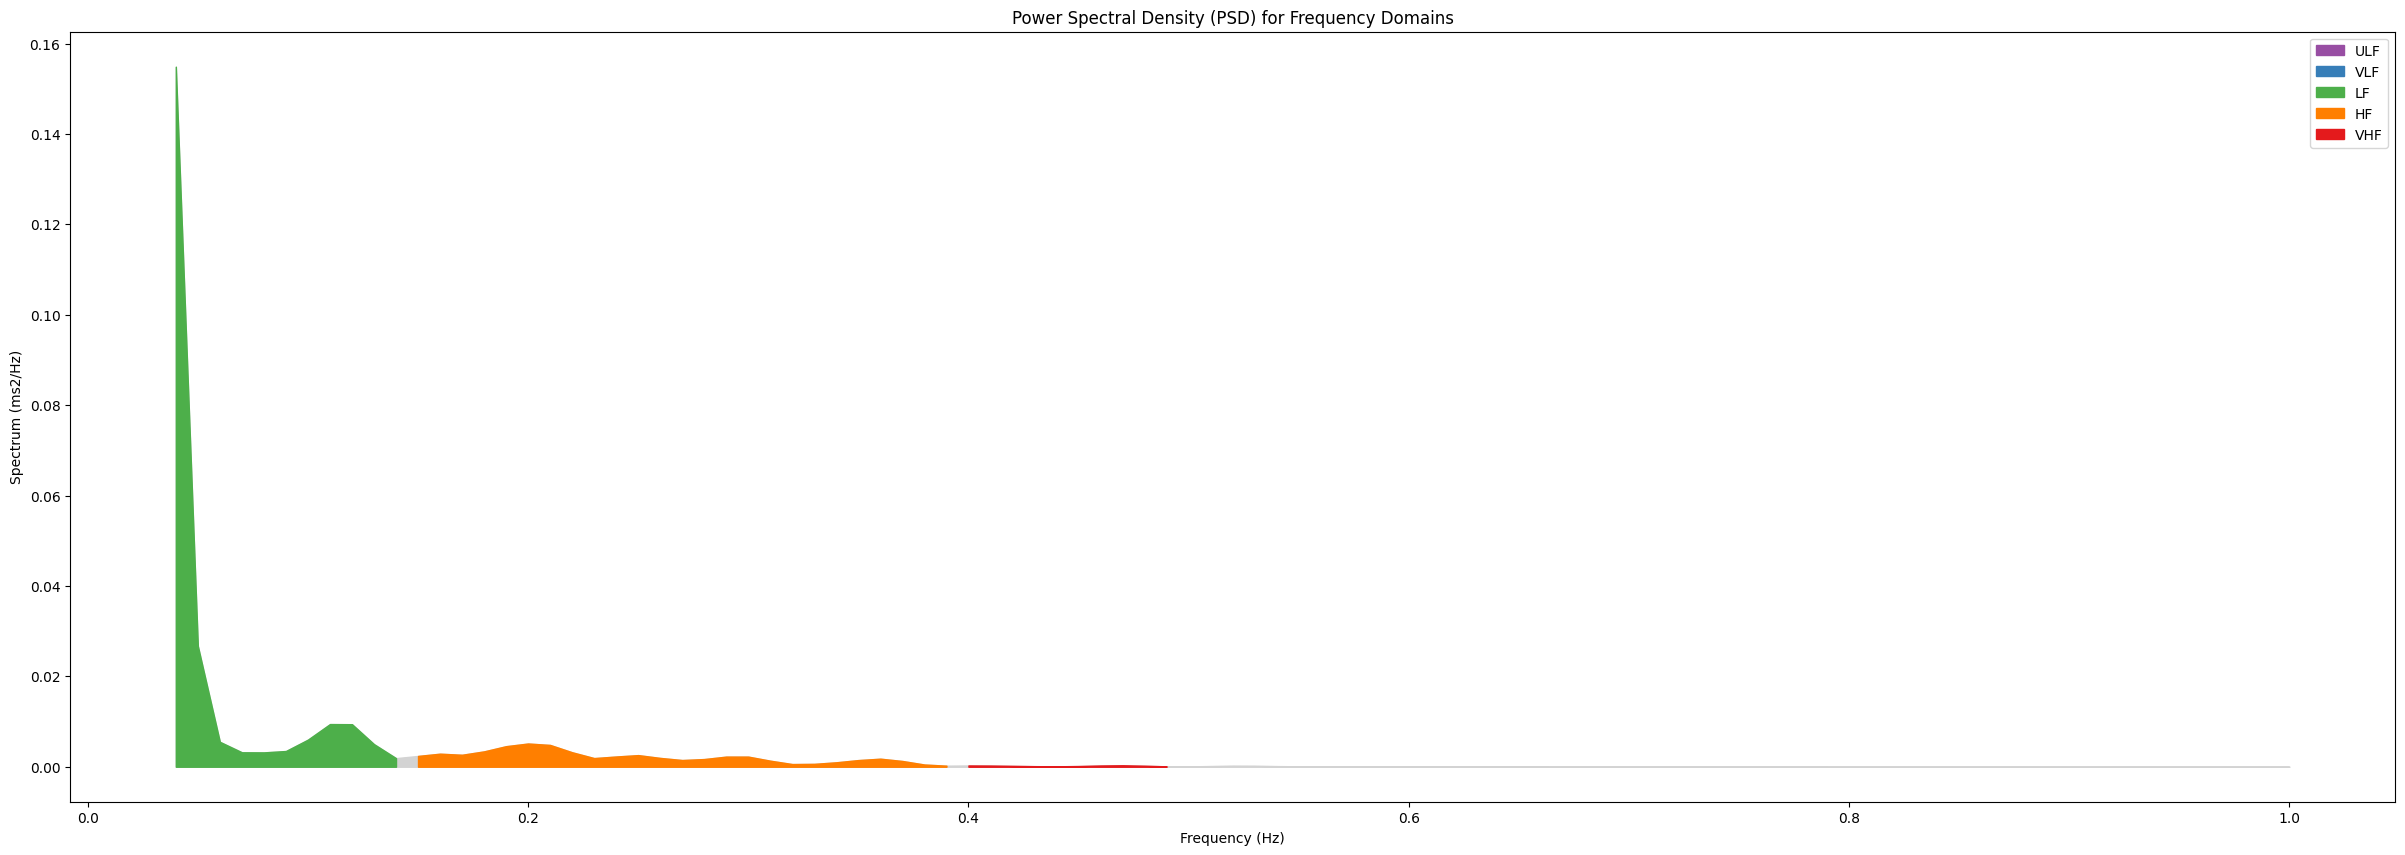

In [12]:
nk.hrv_frequency(df[:2*minute][df[:2*minute]['ECG_R_Peaks'] == 1].index, sampling_rate=1000, show=True)

In [46]:
len(dataset)/minute

144.86666666666667

,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_UHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF
0,0.000113,0.000179,0.000214,0.000012,2.420006e-07,1.162339e-07,0.000518,18.438778,0.412457,0.022369,-11.366258


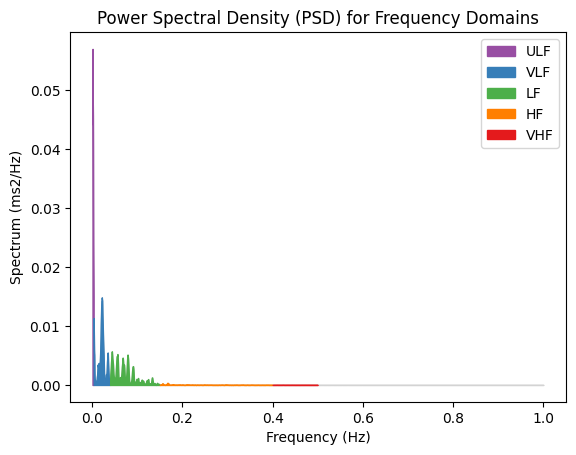

In [10]:
nk.hrv_frequency(df[df['ECG_R_Peaks'] == 1].index, sampling_rate=1000, show=True)

In [11]:
a, b = nk.ecg_delineate(df['ECG_Clean'], sampling_rate=1000, method='peaks')

In [ ]:
df.iloc[:minute]

In [20]:
df.iloc[a.iloc[:minute][a.iloc[:minute]['ECG_T_Peaks'] == 1].index]

,timestamp,signal,signal_normalised,subject_id,category,code,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,...,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
1068,2017-12-15 10:16:07.068000+00:00,0.000443,0.540054,30100,NaN,NaN,0.000443,0.000292,59.250151,0.996414,...,0,0,0,0,0,0,0.0,0.278607,1.0,0.811594
2221,2017-12-15 10:16:08.221000+00:00,0.000407,0.536779,30100,NaN,NaN,0.000407,0.000284,52.373688,0.995191,...,0,0,0,0,0,0,0.0,0.298507,0.0,0.178026
3308,2017-12-15 10:16:09.308000+00:00,0.000491,0.544385,30100,NaN,NaN,0.000491,0.000336,56.097822,0.998854,...,0,0,0,0,0,0,0.0,0.325527,1.0,0.783099
4338,2017-12-15 10:16:10.338000+00:00,0.000496,0.544829,30100,NaN,NaN,0.000496,0.000340,58.169444,0.999187,...,0,0,0,0,0,0,0.0,0.318493,1.0,0.804035
5381,2017-12-15 10:16:11.381000+00:00,0.000462,0.541775,30100,NaN,NaN,0.000462,0.000328,57.842148,0.998593,...,0,0,0,0,0,0,0.0,0.340659,1.0,0.808696
6383,2017-12-15 10:16:12.383000+00:00,0.000450,0.540610,30100,NaN,NaN,0.000450,0.000311,60.439464,0.996248,...,0,0,0,0,0,0,0.0,0.347500,1.0,0.810496
7356,2017-12-15 10:16:13.356000+00:00,0.000401,0.536168,30100,NaN,NaN,0.000401,0.000271,61.256778,0.998139,...,0,0,0,0,0,0,0.0,0.336996,0.0,0.192394
8354,2017-12-15 10:16:14.354000+00:00,0.000450,0.540610,30100,NaN,NaN,0.000450,0.000310,60.205374,0.997327,...,0,0,0,1,0,0,0.0,0.326992,1.0,0.806452
9334,2017-12-15 10:16:15.334000+00:00,0.000539,0.548770,30100,NaN,NaN,0.000539,0.000365,61.736849,0.996155,...,0,0,0,0,0,0,0.0,0.342466,1.0,0.797101
10290,2017-12-15 10:16:16.290000+00:00,0.000437,0.539499,30100,NaN,NaN,0.000437,0.000304,62.658744,0.998658,...,0,0,0,0,0,0,0.0,0.342857,1.0,0.793103


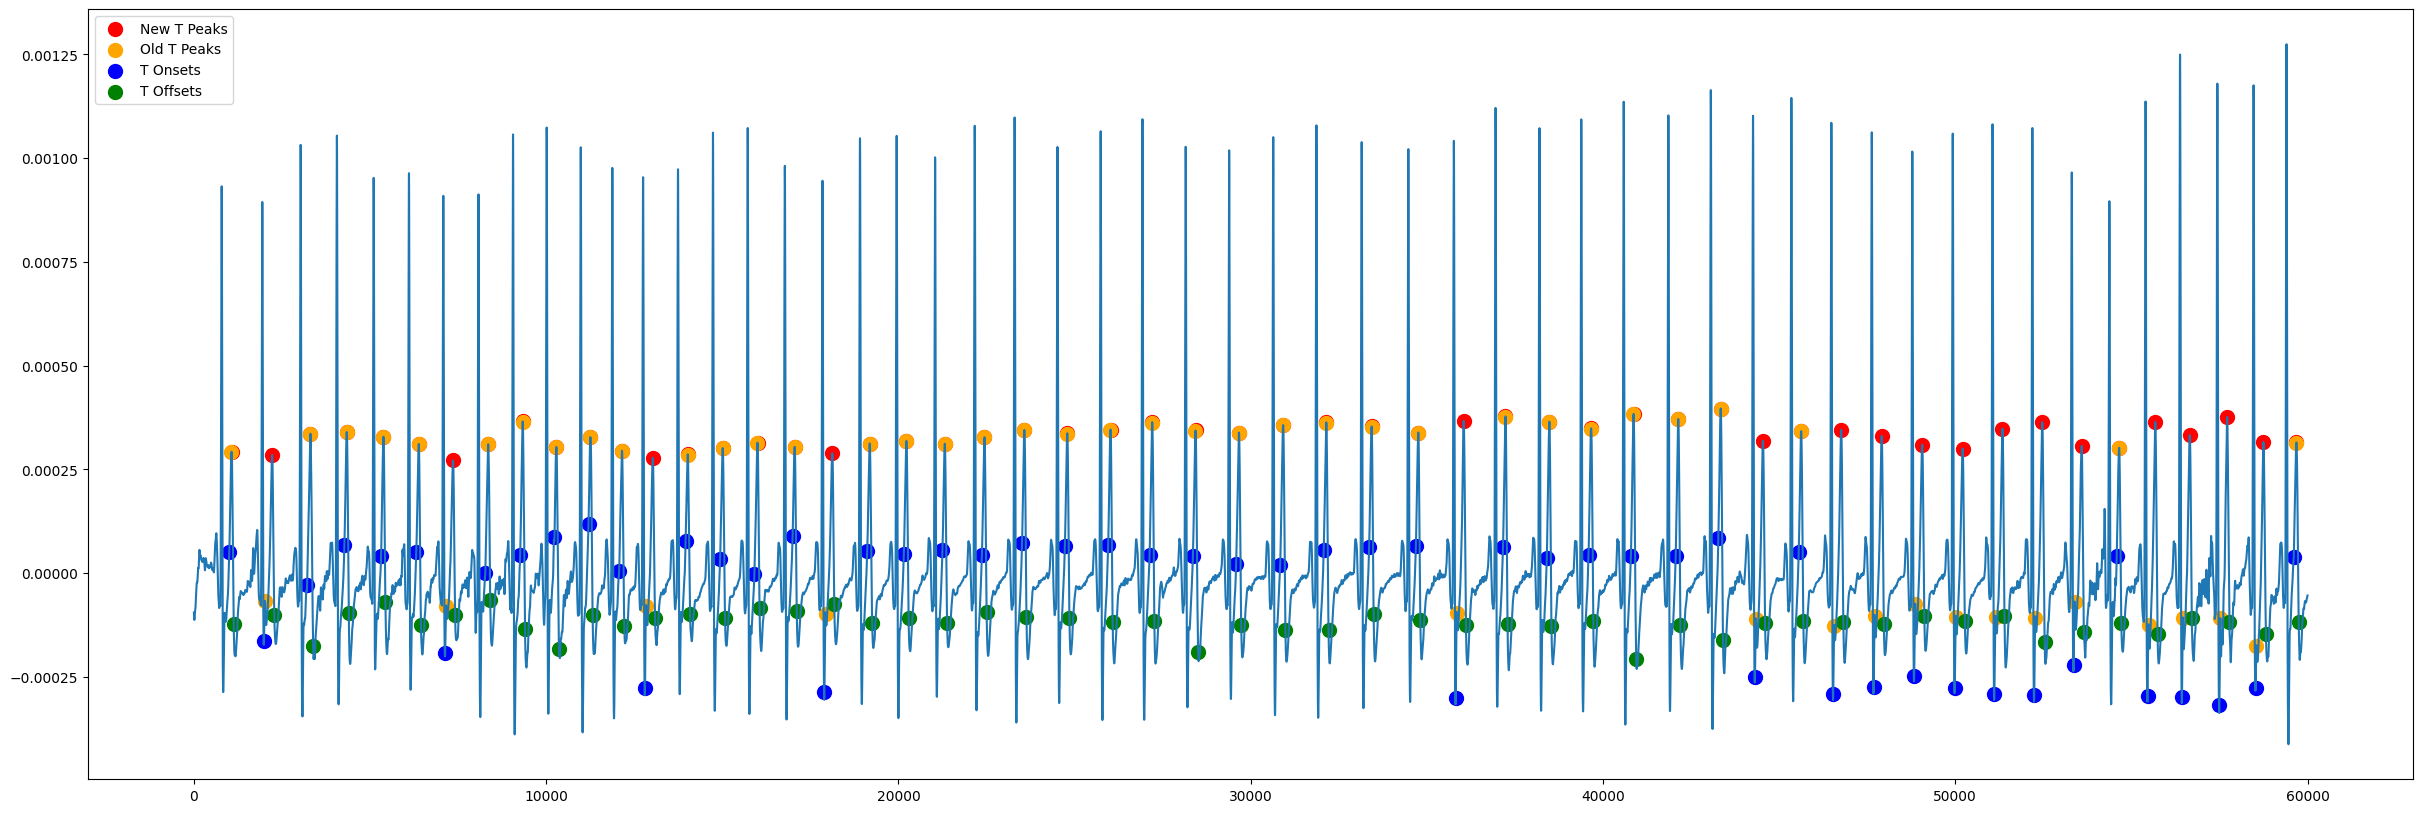

In [28]:
plt.plot(df.iloc[:minute]['ECG_Clean'])
plt.scatter(a.iloc[:minute][a.iloc[:minute]['ECG_T_Peaks'] == 1].index, df.iloc[a.iloc[:minute][a.iloc[:minute]['ECG_T_Peaks'] == 1].index]['ECG_Clean'], color='red', label='New T Peaks', s=100)
plt.scatter(df.iloc[:minute][df.iloc[:minute]['ECG_T_Peaks'] == 1].index, df.iloc[df.iloc[:minute][df.iloc[:minute]['ECG_T_Peaks'] == 1].index]['ECG_Clean'], color='orange', label='Old T Peaks', s=100)
plt.scatter(df.iloc[:minute][df.iloc[:minute]['ECG_T_Onsets'] == 1].index, df.iloc[:minute][df.iloc[:minute]['ECG_T_Onsets'] == 1]['ECG_Clean'], color='blue', label='T Onsets', s=100)
plt.scatter(a.iloc[:minute][a.iloc[:minute]['ECG_T_Offsets'] == 1].index, df.iloc[a.iloc[:minute][a.iloc[:minute]['ECG_T_Offsets'] == 1].index]['ECG_Clean'], color='green', label='T Offsets', s=100)
plt.legend()

### DO NOT EXECUTE BELOW

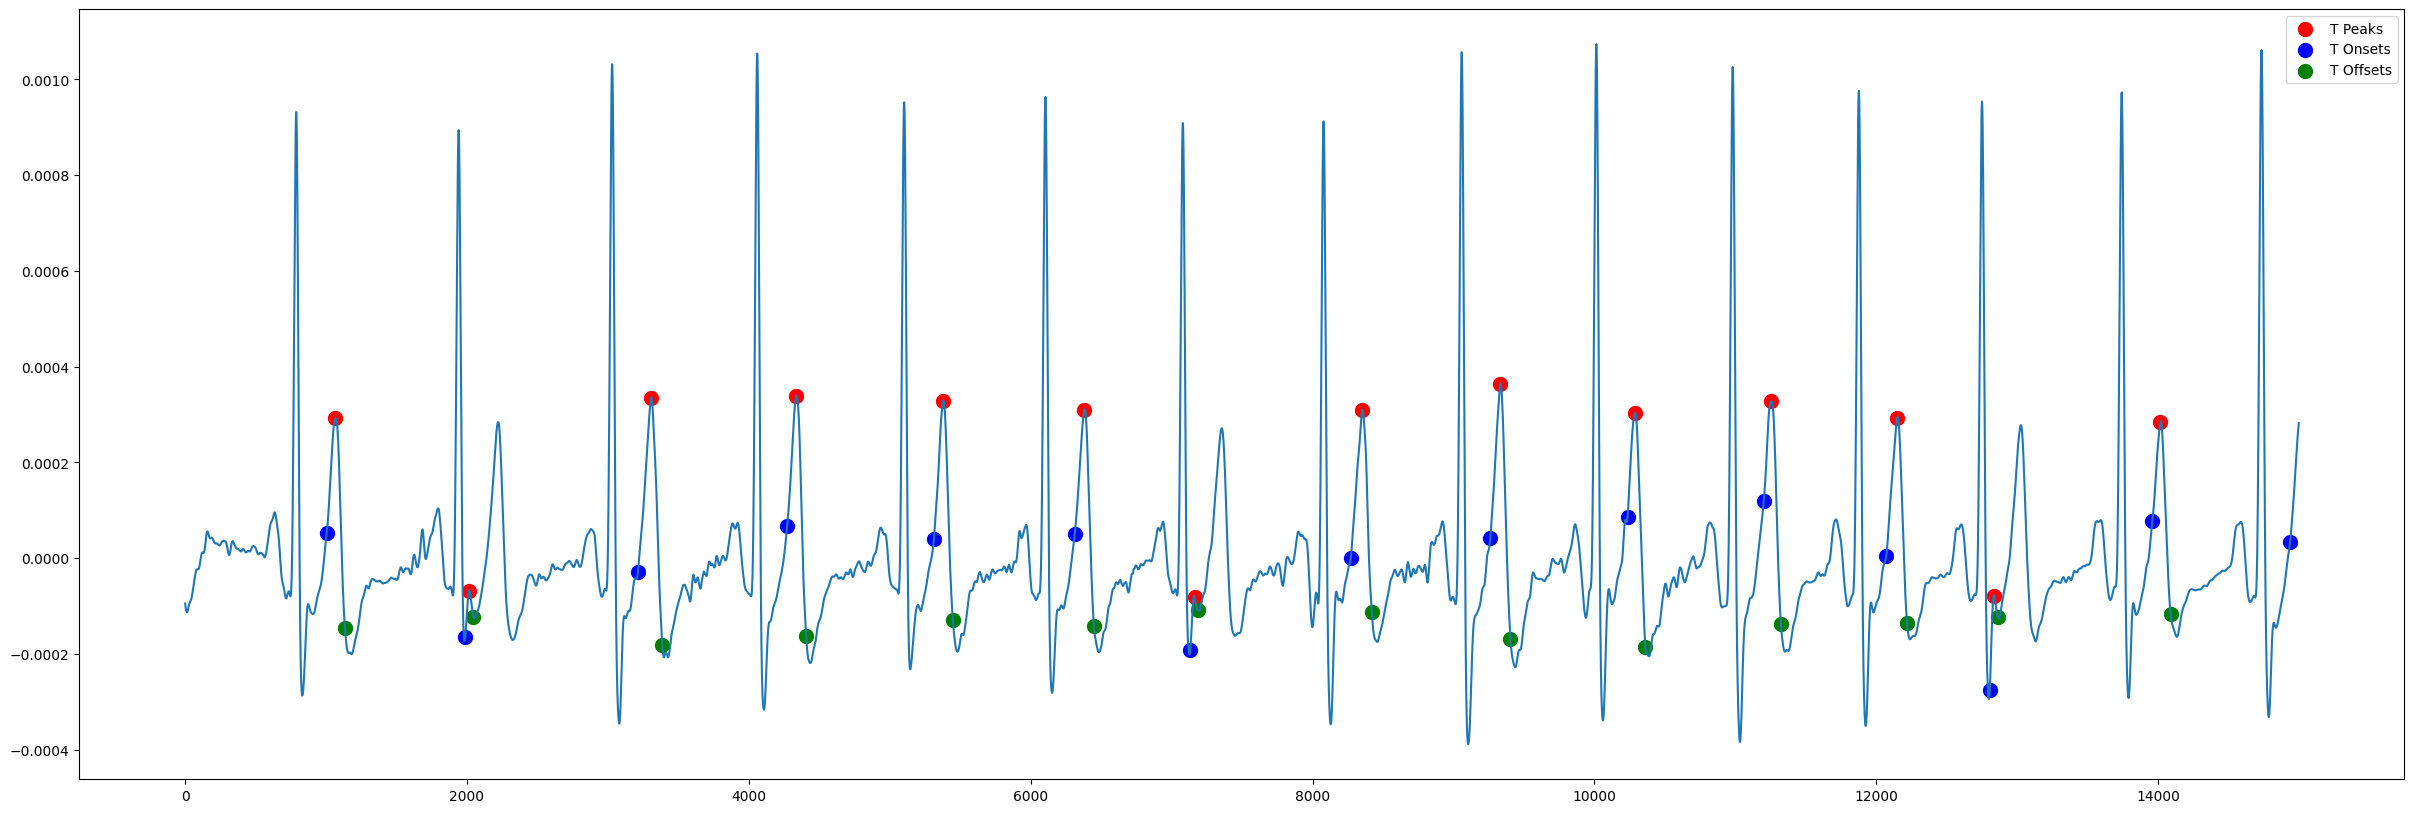

In [39]:
# plt.plot(sample['ECG_Clean'])
# plt.scatter(sample[sample['ECG_T_Peaks'] == 1].index, sample[sample['ECG_T_Peaks'] == 1]['ECG_Clean'], color='red', label='T Peaks', s=100)
# plt.scatter(sample[sample['ECG_T_Onsets'] == 1].index, sample[sample['ECG_T_Onsets'] == 1]['ECG_Clean'], color='blue', label='T Onsets', s=100)
# plt.scatter(sample[sample['ECG_T_Offsets'] == 1].index, sample[sample['ECG_T_Offsets'] == 1]['ECG_Clean'], color='green', label='T Offsets', s=100)
# plt.legend()

(       ECG_P_Peaks  ECG_Q_Peaks  ECG_S_Peaks  ECG_T_Peaks  ECG_P_Onsets  \
 0                0            0            0            0             0   
 1                0            0            0            0             0   
 2                0            0            0            0             0   
 3                0            0            0            0             0   
 4                0            0            0            0             0   
 ...            ...          ...          ...          ...           ...   
 14995            0            0            0            0             0   
 14996            0            0            0            0             0   
 14997            0            0            0            0             0   
 14998            0            0            0            0             0   
 14999            0            0            0            0             0   
 
        ECG_T_Offsets  
 0                  0  
 1                  0  
 2            

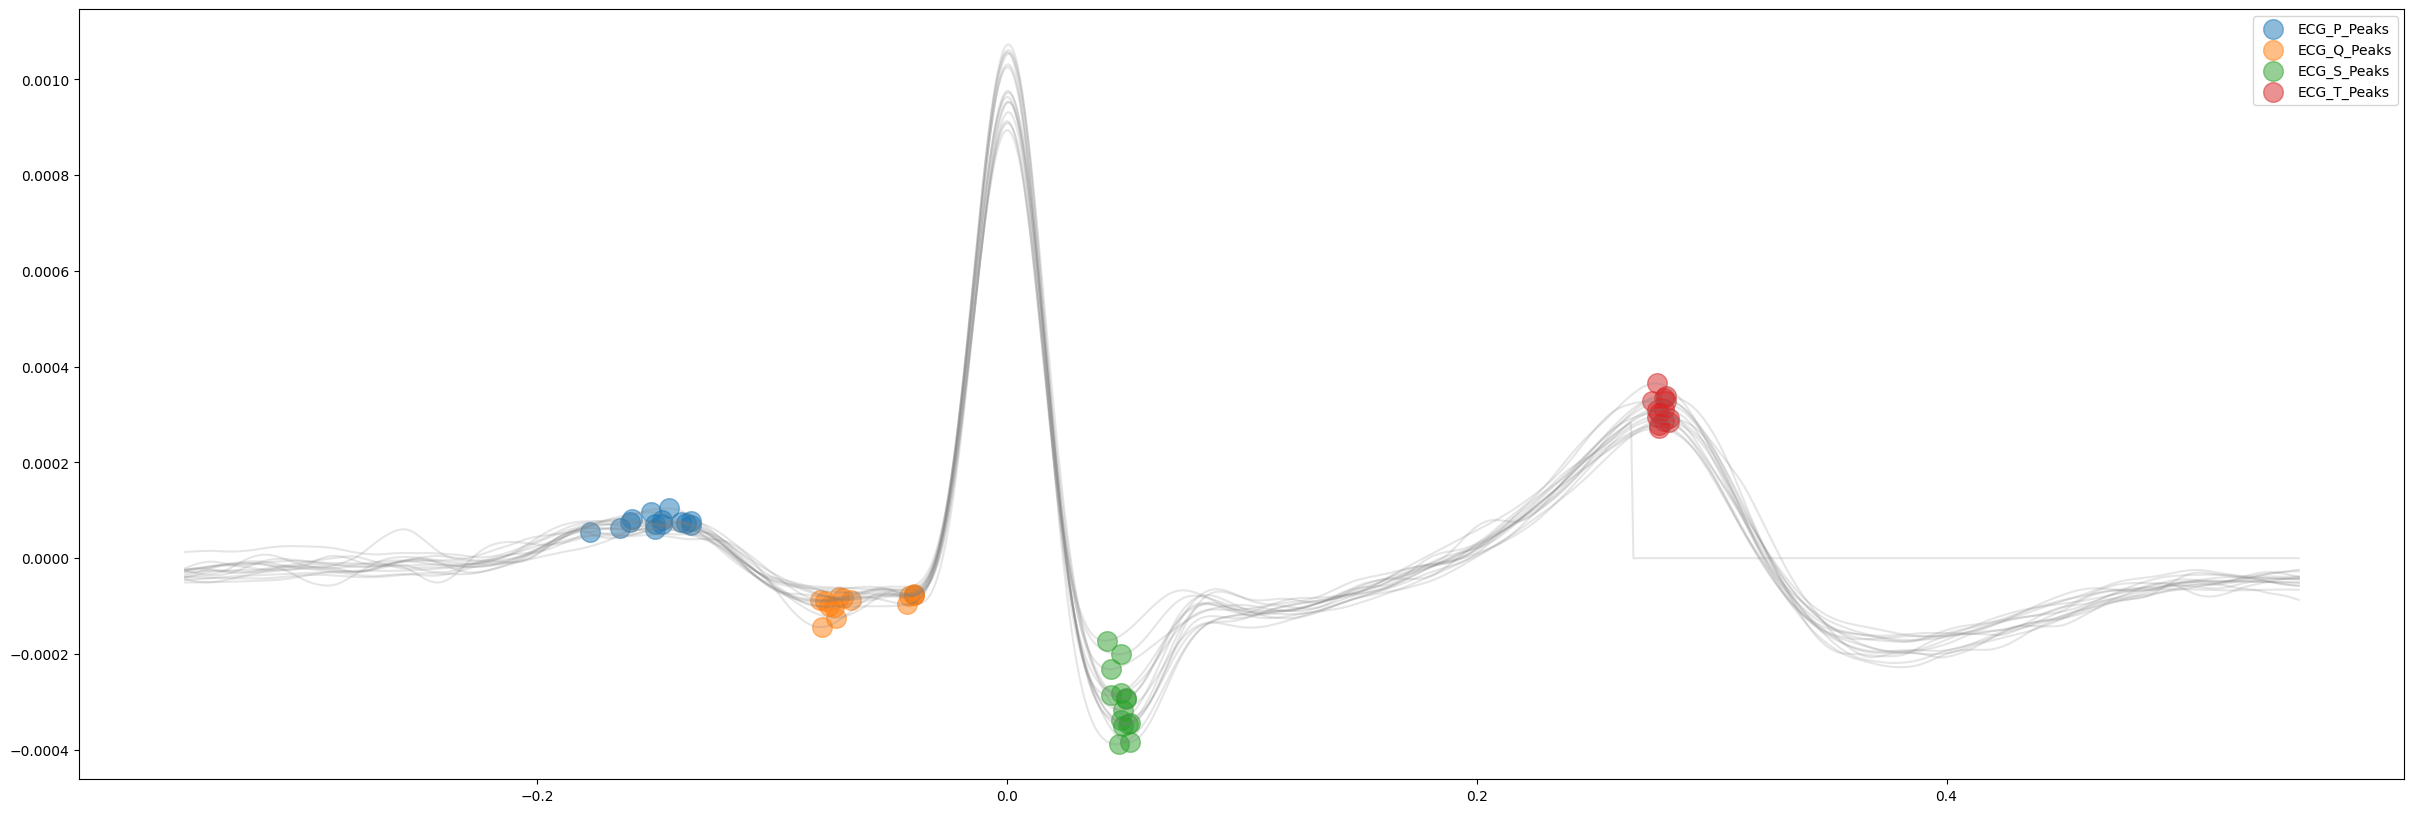

In [43]:
nk.ecg_delineate(sample['ECG_Clean'], method="peaks", sampling_rate=1000, show=True)